In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import numpy as np


In [9]:
print("TensorFlow:", tf.__version__)

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected")
else:
    print("⚠️ Running on CPU")


TensorFlow: 2.10.0
✅ GPU detected


In [10]:
IMAGE_SIZE = 224
BATCH_SIZE = 16     # safe for GPU
CHANNELS = 3
N_CLASSES = 10
EPOCHS = 30


In [13]:
train_dir = "split_dataset/train"
val_dir   = "split_dataset/val"
test_dir  = "split_dataset/test"


In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [15]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",   # ✅ IMPORTANT
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)


Found 18339 images belonging to 10 classes.
Found 2289 images belonging to 10 classes.
Found 2302 images belonging to 10 classes.


In [16]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False


In [17]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(N_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output)


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/30
574/574 [==============================] - 119s 207ms/step - loss: 1.1162 - accuracy: 0.6334 - val_loss: 0.5368 - val_accuracy: 0.8108
Epoch 2/30
574/574 [==============================] - 179s 313ms/step - loss: 0.6067 - accuracy: 0.7946 - val_loss: 0.3951 - val_accuracy: 0.8611
Epoch 3/30
574/574 [==============================] - 197s 344ms/step - loss: 0.4736 - accuracy: 0.8425 - val_loss: 0.3275 - val_accuracy: 0.8816
Epoch 4/30
574/574 [==============================] - 211s 368ms/step - loss: 0.4084 - accuracy: 0.8633 - val_loss: 0.2770 - val_accuracy: 0.9013
Epoch 5/30
574/574 [==============================] - 166s 288ms/step - loss: 0.3584 - accuracy: 0.8811 - val_loss: 0.2634 - val_accuracy: 0.9061
Epoch 6/30
574/574 [==============================] - 109s 190ms/step - loss: 0.3365 - accuracy: 0.8861 - val_loss: 0.2680 - val_accuracy: 0.9004
Epoch 7/30
574/574 [==============================] - 201s 351ms/step - loss: 0.3069 - accuracy: 0.8975 - val_loss: 0.2399 -

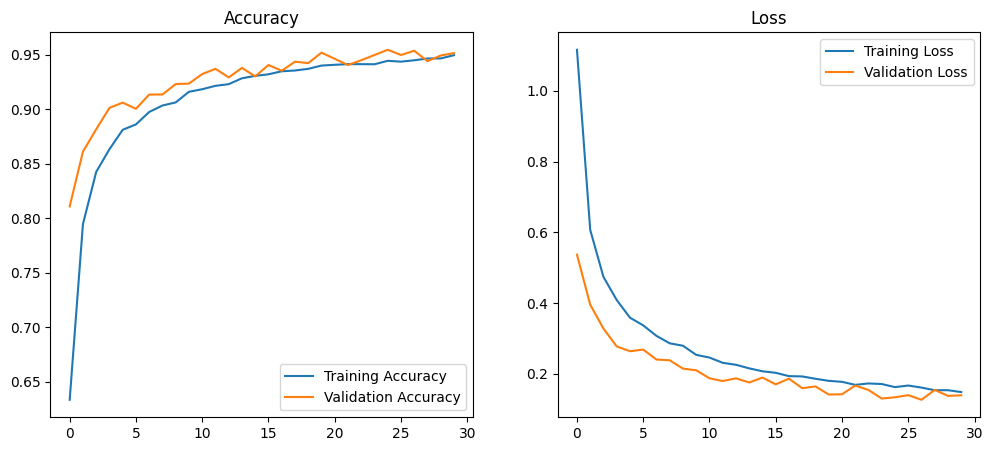

In [22]:
import matplotlib.pyplot as plt
# Plot Accuracy & Loss
# --------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [23]:
# Evaluate Test Set
# --------------------------
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

72/72 [==============================] - 6s 82ms/step - loss: 0.1276 - accuracy: 0.9596
Test Loss: 0.1276, Test Accuracy: 0.9596


72/72 [==============================] - 7s 85ms/step


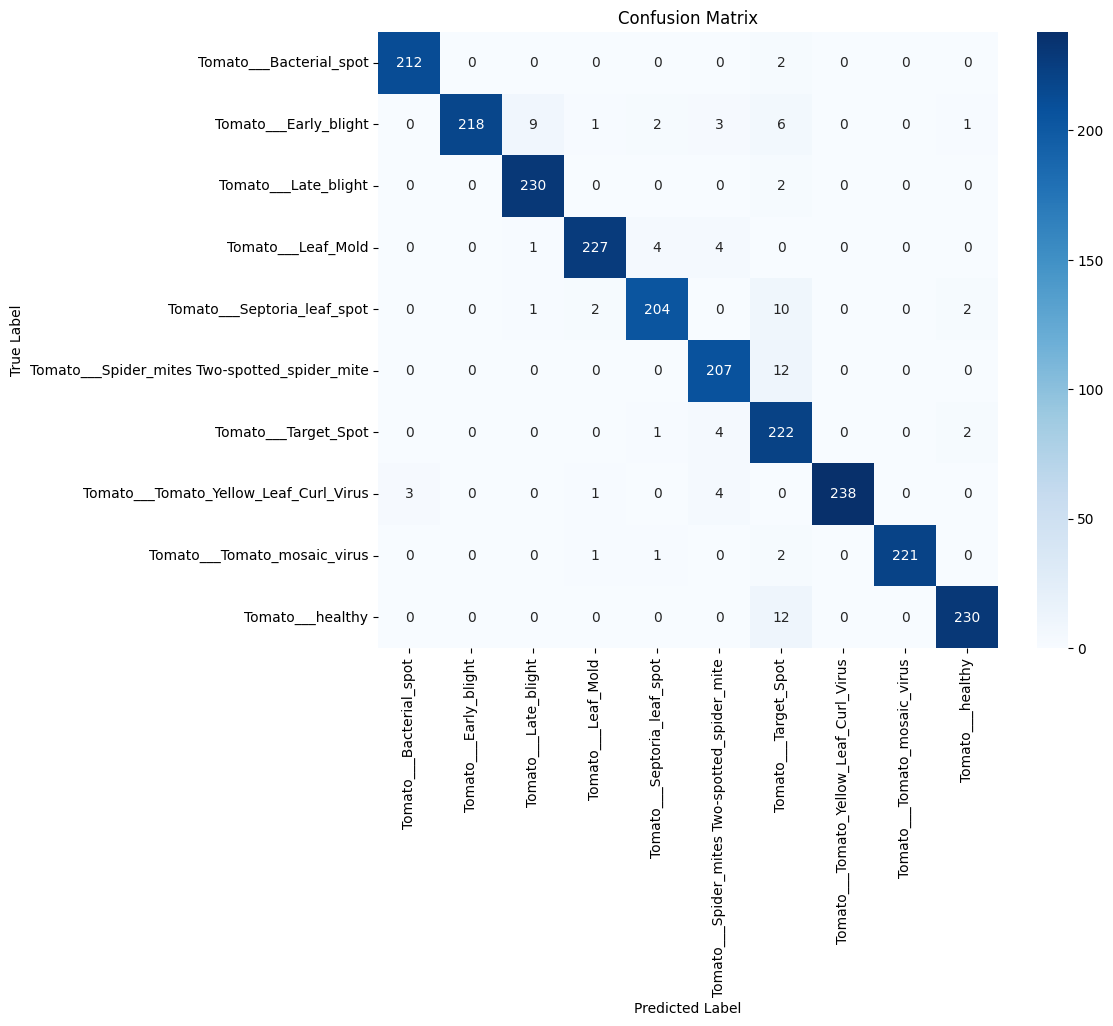

In [24]:
# Confusion Matrix & Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
class_names = list(train_data.class_indices.keys())
# --------------------------
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      0.99      0.99       214
                        Tomato___Early_blight       1.00      0.91      0.95       240
                         Tomato___Late_blight       0.95      0.99      0.97       232
                           Tomato___Leaf_Mold       0.98      0.96      0.97       236
                  Tomato___Septoria_leaf_spot       0.96      0.93      0.95       219
Tomato___Spider_mites Two-spotted_spider_mite       0.93      0.95      0.94       219
                         Tomato___Target_Spot       0.83      0.97      0.89       229
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.97      0.98       246
                 Tomato___Tomato_mosaic_virus       1.00      0.98      0.99       225
                             Tomato___healthy       0.98      0.95      0.96       242

                                     accu

In [28]:
model.save_weights("efficientnetb0_tomato_96pct_weights.h5")

